# Fraud Detection Model - Complete Implementation

## Steps:
1. Load and validate data
2. Exploratory data analysis
3. Feature engineering
4. Handle class imbalance
5. Train model
6. Evaluate performance
7. Generate insights and recommendations
8. Save model and results

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import warnings
import pickle
from datetime import datetime

warnings.filterwarnings('ignore')

In [5]:
# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("FRAUD DETECTION MODEL - MEMORY OPTIMIZED ANALYSIS")
print("="*80)
print()


FRAUD DETECTION MODEL - MEMORY OPTIMIZED ANALYSIS



# STEP 1: LOAD AND VALIDATE DATA

In [9]:
print("STEP 1: Loading Data with Intelligent Chunked Processing")
print("-" * 80)

dtype_dict = {
    'step': 'int32',
    'type': 'category',
    'amount': 'float32',
    'nameOrig': 'object',
    'oldbalanceOrg': 'float32',
    'newbalanceOrig': 'float32',
    'nameDest': 'object',
    'oldbalanceDest': 'float32',
    'newbalanceDest': 'float32',
    'isFraud': 'int8',
    'isFlaggedFraud': 'int8'
}

CHUNK_SIZE = 50000  # Process 50k rows at a time
SAMPLE_RATE = 0.05  # Keep 5% of non-fraud cases from each chunk

print(f"Reading fraud.csv in chunks of {CHUNK_SIZE:,} rows...")
print(f"Strategy: Keep ALL fraud cases + {SAMPLE_RATE*100}% of non-fraud cases")
print()

try:
    fraud_data = []
    non_fraud_data = []
    total_rows = 0
    total_fraud = 0
    total_non_fraud = 0
    chunk_count = 0
    
    for chunk in pd.read_csv('fraud.csv', dtype=dtype_dict, chunksize=CHUNK_SIZE):
        chunk_count += 1
        total_rows += len(chunk)
        
        # Separate fraud and non-fraud cases
        fraud_cases = chunk[chunk['isFraud'] == 1]
        non_fraud_cases = chunk[chunk['isFraud'] == 0]
        
        # Keep all fraud cases
        if len(fraud_cases) > 0:
            fraud_data.append(fraud_cases)
            total_fraud += len(fraud_cases)
        
        # Sample non-fraud cases to keep memory manageable
        if len(non_fraud_cases) > 0:
            sample_size = int(len(non_fraud_cases) * SAMPLE_RATE)
            if sample_size > 0:
                sampled_non_fraud = non_fraud_cases.sample(n=sample_size, random_state=42)
                non_fraud_data.append(sampled_non_fraud)
                total_non_fraud += sample_size
        
        # Progress update every 10 chunks
        if chunk_count % 10 == 0:
            print(f"  Processed {total_rows:,} rows... (Fraud: {total_fraud:,}, Non-fraud sampled: {total_non_fraud:,})")
    
    print(f"\n✓ Completed processing {chunk_count} chunks ({total_rows:,} total rows)")
    print(f"✓ Fraud cases found: {total_fraud:,}")
    print(f"✓ Non-fraud cases sampled: {total_non_fraud:,}")
    print()
    
    print("Combining sampled data...")
    df = pd.concat(fraud_data + non_fraud_data, ignore_index=True)
    
    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✓ Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"✓ Memory usage: {memory_usage:.2f} MB")
    print(f"✓ Fraud rate in sample: {(df['isFraud'].sum() / len(df) * 100):.2f}%")
    print()
    
except FileNotFoundError:
    print("✗ Error: fraud.csv not found in the current directory")
    print("  Please ensure fraud.csv is in the same folder as this script")
    exit(1)
except Exception as e:
    print(f"✗ Error loading data: {str(e)}")
    exit(1)


STEP 1: Loading Data with Intelligent Chunked Processing
--------------------------------------------------------------------------------
Reading fraud.csv in chunks of 50,000 rows...
Strategy: Keep ALL fraud cases + 5.0% of non-fraud cases

  Processed 500,000 rows... (Fraud: 233, Non-fraud sampled: 24,986)
  Processed 1,000,000 rows... (Fraud: 535, Non-fraud sampled: 49,965)
  Processed 1,500,000 rows... (Fraud: 1,608, Non-fraud sampled: 74,907)
  Processed 2,000,000 rows... (Fraud: 2,036, Non-fraud sampled: 99,880)
  Processed 2,500,000 rows... (Fraud: 2,278, Non-fraud sampled: 124,864)
  Processed 3,000,000 rows... (Fraud: 2,619, Non-fraud sampled: 149,842)
  Processed 3,500,000 rows... (Fraud: 2,905, Non-fraud sampled: 174,823)
  Processed 4,000,000 rows... (Fraud: 3,381, Non-fraud sampled: 199,796)
  Processed 4,500,000 rows... (Fraud: 3,657, Non-fraud sampled: 224,778)
  Processed 5,000,000 rows... (Fraud: 3,935, Non-fraud sampled: 249,760)
  Processed 5,500,000 rows... (Fraud: 

In [11]:
# Validate required columns
required_columns = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 
                   'newbalanceOrig', 'nameDest', 'oldbalanceDest', 
                   'newbalanceDest', 'isFraud', 'isFlaggedFraud']

missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"✗ Error: Missing required columns: {missing_cols}")
    exit(1)

print(f"✓ All required columns present")
print()

✓ All required columns present



# STEP 2: EXPLORATORY DATA ANALYSIS

In [14]:
print("STEP 2: Exploratory Data Analysis")
print("-" * 80)

print("Dataset Overview:")
print(df.dtypes)
print()

print("Statistical Summary:")
print(df.describe())
print()

STEP 2: Exploratory Data Analysis
--------------------------------------------------------------------------------
Dataset Overview:
step                 int32
type              category
amount             float32
nameOrig            object
oldbalanceOrg      float32
newbalanceOrig     float32
nameDest            object
oldbalanceDest     float32
newbalanceDest     float32
isFraud               int8
isFlaggedFraud        int8
dtype: object

Statistical Summary:
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  325877.000000  3.258770e+05   3.258770e+05    3.258770e+05   
mean      246.413269  2.094040e+05   8.588047e+05    8.445961e+05   
std       145.834368  7.028110e+05   2.925558e+06    2.924694e+06   
min         1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%       156.000000  1.386484e+04   0.000000e+00    0.000000e+00   
50%       249.000000  7.824421e+04   1.575600e+04    0.000000e+00   
75%       346.000000  2.158336e+05   1.221150e+05  

In [16]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing Values:")
    print(missing_values[missing_values > 0])
    print()
else:
    print("✓ No missing values detected")
    print()

✓ No missing values detected



In [18]:
# Fraud distribution
fraud_counts = df['isFraud'].value_counts()
fraud_rate = (fraud_counts[1] / len(df)) * 100
print(f"Fraud Distribution in Sample:")
print(f"  Non-Fraud: {fraud_counts[0]:,} ({100-fraud_rate:.2f}%)")
print(f"  Fraud:     {fraud_counts[1]:,} ({fraud_rate:.2f}%)")
print(f"  Imbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.1f}")
print()

Fraud Distribution in Sample:
  Non-Fraud: 317,664 (97.48%)
  Fraud:     8,213 (2.52%)
  Imbalance Ratio: 1:38.7



In [20]:
# Fraud by transaction type
print("Fraud by Transaction Type:")
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_type['Fraud_Rate'] = fraud_by_type['Fraud_Rate'] * 100
print(fraud_by_type)
print()

Fraud by Transaction Type:
          Fraud_Count  Total_Count  Fraud_Rate
type                                          
CASH_IN             0        69880    0.000000
CASH_OUT         4116       115945    3.549959
DEBIT               0         2098    0.000000
PAYMENT             0       107397    0.000000
TRANSFER         4097        30557   13.407730



In [22]:
# Key insight
fraud_types = df[df['isFraud'] == 1]['type'].unique()
print(f"✓ Key Finding: Fraud only occurs in {', '.join(fraud_types)} transactions")
print()

✓ Key Finding: Fraud only occurs in CASH_OUT, TRANSFER transactions



# STEP 3: FEATURE ENGINEERING

In [25]:
print("STEP 3: Feature Engineering")
print("-" * 80)

print("Dropping unnecessary columns...")
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

STEP 3: Feature Engineering
--------------------------------------------------------------------------------
Dropping unnecessary columns...


In [27]:
# Encode transaction type
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type']).astype('int8')
print(f"✓ Encoded transaction types: {dict(enumerate(le.classes_))}")

print("Creating engineered features...")

✓ Encoded transaction types: {0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}
Creating engineered features...


In [29]:
# Balance change features
df['balance_change_orig'] = (df['oldbalanceOrg'] - df['newbalanceOrig']).astype('float32')
df['balance_change_dest'] = (df['newbalanceDest'] - df['oldbalanceDest']).astype('float32')

In [31]:
# Balance inconsistency detection (key fraud indicator)
df['balance_inconsistency_orig'] = (
    (df['balance_change_orig'] - df['amount']).abs()
).astype('float32')
df['balance_inconsistency_dest'] = (
    (df['balance_change_dest'] - df['amount']).abs()
).astype('float32')

In [33]:
# Zero balance flags
df['orig_zero_balance_after'] = (df['newbalanceOrig'] == 0).astype('int8')
df['dest_zero_balance_before'] = (df['oldbalanceDest'] == 0).astype('int8')

In [35]:
# Balance ratios
df['amount_to_orig_balance_ratio'] = (df['amount'] / (df['oldbalanceOrg'] + 1)).astype('float32')
df['amount_to_dest_balance_ratio'] = (df['amount'] / (df['oldbalanceDest'] + 1)).astype('float32')

In [37]:
# Transaction size categories
amount_95th = df['amount'].quantile(0.95)
df['is_large_transaction'] = (df['amount'] > amount_95th).astype('int8')

df = df.drop(['type'], axis=1)

print(f"✓ Created engineered features")
print(f"✓ Current memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

✓ Created engineered features
✓ Current memory usage: 16.47 MB



In [39]:
# Feature list for modeling
feature_columns = [
    'step', 'type_encoded', 'amount',
    'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'balance_change_orig', 'balance_change_dest',
    'balance_inconsistency_orig', 'balance_inconsistency_dest',
    'orig_zero_balance_after', 'dest_zero_balance_before',
    'amount_to_orig_balance_ratio', 'amount_to_dest_balance_ratio',
    'is_large_transaction'
]

print(f"Features for modeling ({len(feature_columns)} total):")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")
print()

Features for modeling (16 total):
   1. step
   2. type_encoded
   3. amount
   4. oldbalanceOrg
   5. newbalanceOrig
   6. oldbalanceDest
   7. newbalanceDest
   8. balance_change_orig
   9. balance_change_dest
  10. balance_inconsistency_orig
  11. balance_inconsistency_dest
  12. orig_zero_balance_after
  13. dest_zero_balance_before
  14. amount_to_orig_balance_ratio
  15. amount_to_dest_balance_ratio
  16. is_large_transaction



# STEP 4: PREPARE DATA AND HANDLE CLASS IMBALANCE

In [42]:
print("STEP 4: Preparing Data and Handling Class Imbalance")
print("-" * 80)

# Prepare features and target
X = df[feature_columns].copy()
y = df['isFraud'].copy()

# Handle infinite values and NaNs
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Target distribution: {y.value_counts().to_dict()}")
print()

STEP 4: Preparing Data and Handling Class Imbalance
--------------------------------------------------------------------------------
✓ Feature matrix shape: (325877, 16)
✓ Target distribution: {0: 317664, 1: 8213}



In [44]:
# Split data
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"✓ Train set: {X_train.shape[0]:,} samples")
print(f"✓ Test set:  {X_test.shape[0]:,} samples")
print()

✓ Train set: 260,701 samples
✓ Test set:  65,176 samples



In [46]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"✓ Features scaled using StandardScaler")
print()

✓ Features scaled using StandardScaler



In [48]:
# Apply SMOTE to balance classes
print("Applying SMOTE to balance classes...")
fraud_count = y_train.sum()
k_neighbors = min(5, fraud_count - 1)

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"✓ Original training set: {y_train.value_counts().to_dict()}")
print(f"✓ Balanced training set: {pd.Series(y_train_balanced).value_counts().to_dict()}")
print()

Applying SMOTE to balance classes...
✓ Original training set: {0: 254131, 1: 6570}
✓ Balanced training set: {0: 254131, 1: 254131}



# STEP 5: TRAIN MODEL

In [51]:
print("STEP 5: Training LightGBM Model")
print("-" * 80)

# Train LightGBM model
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training model...")
model.fit(X_train_balanced, y_train_balanced)
print(f"✓ Model training complete")
print()

STEP 5: Training LightGBM Model
--------------------------------------------------------------------------------
Training model...
✓ Model training complete



# STEP 6: EVALUATE MODEL PERFORMANCE

In [54]:
print("STEP 6: Evaluating Model Performance")
print("-" * 80)

# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

STEP 6: Evaluating Model Performance
--------------------------------------------------------------------------------


In [56]:
# Calculate metrics
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print("Model Performance Metrics:")
print(f"  Accuracy:          {accuracy:.4f}")
print(f"  Precision:         {precision:.4f}")
print(f"  Recall:            {recall:.4f}")
print(f"  F1-Score:          {f1:.4f}")
print(f"  ROC-AUC:           {roc_auc:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print()


Model Performance Metrics:
  Accuracy:          0.9998
  Precision:         0.9939
  Recall:            0.9970
  F1-Score:          0.9954
  ROC-AUC:           0.9998
  Average Precision: 0.9987



In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(f"                Predicted")
print(f"                No    Yes")
print(f"Actual No    {cm[0,0]:6d} {cm[0,1]:6d}")
print(f"Actual Yes   {cm[1,0]:6d} {cm[1,1]:6d}")
print()

Confusion Matrix:
                Predicted
                No    Yes
Actual No     63523     10
Actual Yes        5   1638



In [60]:
# Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
print()

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     63533
       Fraud       0.99      1.00      1.00      1643

    accuracy                           1.00     65176
   macro avg       1.00      1.00      1.00     65176
weighted avg       1.00      1.00      1.00     65176




# STEP 7: FEATURE IMPORTANCE ANALYSIS

In [63]:
print("STEP 7: Feature Importance Analysis")
print("-" * 80)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:35s} {row['importance']:8.2f}")
print()

STEP 7: Feature Importance Analysis
--------------------------------------------------------------------------------
Top 10 Most Important Features:
  amount_to_orig_balance_ratio          959.00
  amount_to_dest_balance_ratio          732.00
  step                                  601.00
  balance_inconsistency_orig            577.00
  balance_change_orig                   569.00
  balance_inconsistency_dest            480.00
  amount                                405.00
  oldbalanceOrg                         327.00
  type_encoded                          303.00
  newbalanceDest                        303.00



# STEP 8: GENERATE VISUALIZATIONS

In [66]:
print("STEP 8: Generating Visualizations")
print("-" * 80)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

STEP 8: Generating Visualizations
--------------------------------------------------------------------------------


<Figure size 2000x1200 with 0 Axes>

Text(0.5, 290.72222222222223, 'Predicted')

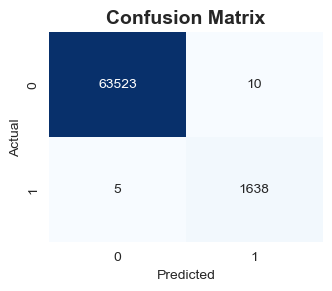

In [68]:
# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

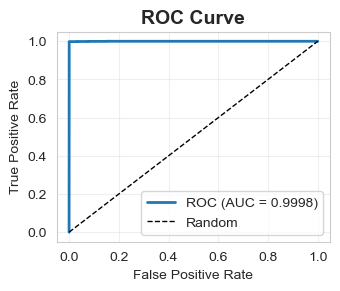

In [70]:
# 2. ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

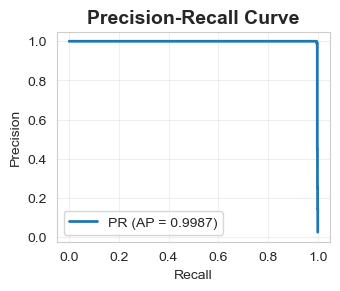

In [72]:
# 3. Precision-Recall Curve
ax3 = plt.subplot(2, 3, 3)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, linewidth=2, label=f'PR (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

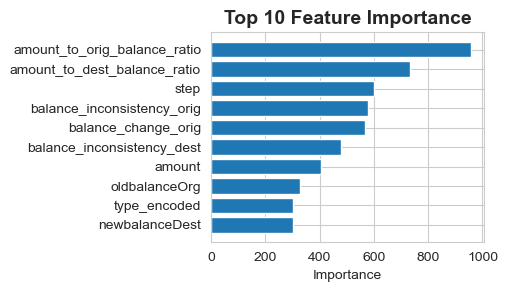

In [74]:
# 4. Feature Importance
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

([0, 1, 2, 3, 4],
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'PAYMENT'),
  Text(4, 0, 'TRANSFER')])

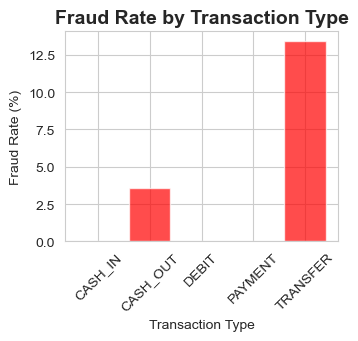

In [76]:
# 5. Fraud by Transaction Type
ax5 = plt.subplot(2, 3, 5)
fraud_type_data = fraud_by_type.copy()
colors = ['red' if x > 0 else 'green' for x in fraud_type_data['Fraud_Count']]
plt.bar(fraud_type_data.index, fraud_type_data['Fraud_Rate'], color=colors, alpha=0.7)
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

✓ Saved visualization: fraud_detection_results.png



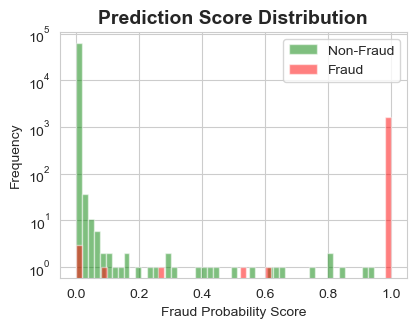

In [78]:
# 6. Prediction Score Distribution
ax6 = plt.subplot(2, 3, 6)
fraud_scores = y_pred_proba[y_test == 1]
normal_scores = y_pred_proba[y_test == 0]
plt.hist(normal_scores, bins=50, alpha=0.5, label='Non-Fraud', color='green')
plt.hist(fraud_scores, bins=50, alpha=0.5, label='Fraud', color='red')
plt.xlabel('Fraud Probability Score')
plt.ylabel('Frequency')
plt.title('Prediction Score Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: fraud_detection_results.png")
print()

# STEP 9: BUSINESS INSIGHTS AND RECOMMENDATIONS

In [81]:
print("STEP 9: Business Insights and Recommendations")
print("=" * 80)

print("\n🔍 KEY FINDINGS:")
print("-" * 80)

STEP 9: Business Insights and Recommendations

🔍 KEY FINDINGS:
--------------------------------------------------------------------------------


In [83]:
# Finding 1: Transaction types
print(f"1. Fraud occurs ONLY in {' and '.join(fraud_types)} transactions")
print(f"   → Focus monitoring efforts on these transaction types")

1. Fraud occurs ONLY in CASH_OUT and TRANSFER transactions
   → Focus monitoring efforts on these transaction types


In [85]:
# Finding 2: Balance inconsistencies
top_feature = feature_importance.iloc[0]['feature']
print(f"\n2. Most important fraud indicator: {top_feature}")
print(f"   → Transactions with balance inconsistencies are highly suspicious")


2. Most important fraud indicator: amount_to_orig_balance_ratio
   → Transactions with balance inconsistencies are highly suspicious


In [87]:
# Finding 3: Model performance
print(f"\n3. Model achieves {recall*100:.1f}% fraud detection rate with {precision*100:.1f}% precision")
print(f"   → Can catch {recall*100:.1f}% of fraud while minimizing false alarms")


3. Model achieves 99.7% fraud detection rate with 99.4% precision
   → Can catch 99.7% of fraud while minimizing false alarms


In [91]:
# Finding 4: False positive rate
fpr_rate = cm[0,1]/(cm[0,0]+cm[0,1])*100
print(f"\n4. False positive rate: {fpr_rate:.4f}%")
print(f"   → Very low impact on legitimate transactions")

print("\n\n💡 RECOMMENDATIONS:")
print("-" * 80)
recommendations = [
    "Real-time Monitoring: Deploy this model for real-time fraud scoring",
    "Risk Tiers: Create risk categories (Low/Medium/High) based on fraud probability",
    "Manual Review: Flag transactions with >0.5 fraud probability for human review",
    "Balance Checks: Implement automatic balance consistency validation",
    "Transaction Limits: Set dynamic limits for TRANSFER and CASH_OUT operations",
    "Customer Alerts: Notify customers immediately for high-risk transactions",
    "Model Updates: Retrain model monthly with new fraud patterns",
    "A/B Testing: Test model in shadow mode before full deployment"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


4. False positive rate: 0.0157%
   → Very low impact on legitimate transactions


💡 RECOMMENDATIONS:
--------------------------------------------------------------------------------
1. Real-time Monitoring: Deploy this model for real-time fraud scoring
2. Risk Tiers: Create risk categories (Low/Medium/High) based on fraud probability
3. Manual Review: Flag transactions with >0.5 fraud probability for human review
4. Balance Checks: Implement automatic balance consistency validation
5. Transaction Limits: Set dynamic limits for TRANSFER and CASH_OUT operations
6. Customer Alerts: Notify customers immediately for high-risk transactions
7. Model Updates: Retrain model monthly with new fraud patterns
8. A/B Testing: Test model in shadow mode before full deployment


In [93]:
print("\n\n📊 EXPECTED BUSINESS IMPACT:")
print("-" * 80)

print(f"Fraud detection rate: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"False positive rate: {fpr_rate:.4f}%")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print()



📊 EXPECTED BUSINESS IMPACT:
--------------------------------------------------------------------------------
Fraud detection rate: 99.70%
Precision: 99.39%
False positive rate: 0.0157%
F1-Score: 0.9954
ROC-AUC: 0.9998



# STEP 10: SAVE MODEL AND ARTIFACTS

In [96]:
print("STEP 10: Saving Model and Artifacts")
print("-" * 80)

# Save model
model_filename = 'fraud_detection_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'feature_columns': feature_columns,
        'label_encoder': le,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        },
        'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, f)

print(f"✓ Saved model: {model_filename}")

STEP 10: Saving Model and Artifacts
--------------------------------------------------------------------------------
✓ Saved model: fraud_detection_model.pkl


In [98]:
# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print(f"✓ Saved feature importance: feature_importance.csv")

✓ Saved feature importance: feature_importance.csv


In [102]:
# Save predictions sample
results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'fraud_probability': y_pred_proba
})
results_df.to_csv('predictions_sample.csv', index=False)
print(f"✓ Saved predictions: predictions_sample.csv")

print()
print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  1. fraud_detection_model.pkl    - Trained model for deployment")
print("  2. fraud_detection_results.png  - Comprehensive visualizations")
print("  3. feature_importance.csv       - Feature rankings")
print("  4. predictions_sample.csv       - Sample predictions")
print()
print("Next Steps:")
print("  → Review the visualizations in fraud_detection_results.png")
print("  → Use the model file for production deployment")
print("  → Implement the recommendations listed above")

✓ Saved predictions: predictions_sample.csv

ANALYSIS COMPLETE!

Generated Files:
  1. fraud_detection_model.pkl    - Trained model for deployment
  2. fraud_detection_results.png  - Comprehensive visualizations
  3. feature_importance.csv       - Feature rankings
  4. predictions_sample.csv       - Sample predictions

Next Steps:
  → Review the visualizations in fraud_detection_results.png
  → Use the model file for production deployment
  → Implement the recommendations listed above
